In [1]:
from __future__ import print_function, division

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
import os

In [4]:
import context
from hier_clust import HierClust
from hier_clust.tree_util import Tree

In [5]:
from impurity_utils import (
    construct_random_tree,
    convert_linkage_to_tree,
    random_leaf_impurity,
    avg_gini_impurity_tree,
    avg_gini_impurity_from_assignments,
    gini_impurity_single_node,
    add_counters_to_tree,
)

In [6]:
import scipy.cluster.hierarchy as sch

In [7]:
base_dir = "/Users/aleverentz/Downloads/cifar-10-batches-bin"

In [8]:
with open(os.path.join(base_dir, "batches.meta.txt")) as f:
    label_names = [line.rstrip() for line in f.readlines()]

In [9]:
n_obs = 1000

In [10]:
with open(os.path.join(base_dir, "data_batch_1.bin"), "rb") as f:
    labels = []
    vectors = []
    imgs = []
    
    for i in range(n_obs):
        label = ord(f.read(1))
        vector = bytearray(f.read(1024 * 3))
        img = np.array(vector).reshape((3, 32, 32)).transpose((1, 2, 0))
        
        labels.append(label)
        vectors.append(vector)
        imgs.append(img)

labels = np.asarray(labels)
vectors = np.asarray(vectors)

In [11]:
print(labels.shape)
print(vectors.shape)

(1000,)
(1000, 3072)


In [12]:
label, label_names[label]

(5, 'dog')

In [13]:
img.shape

(32, 32, 3)

In [14]:
def my_imshow(img, title=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    ax.imshow(img, interpolation="none")
    ax.axis("off")
    if title is not None:
        ax.set_title(title)
    return ax

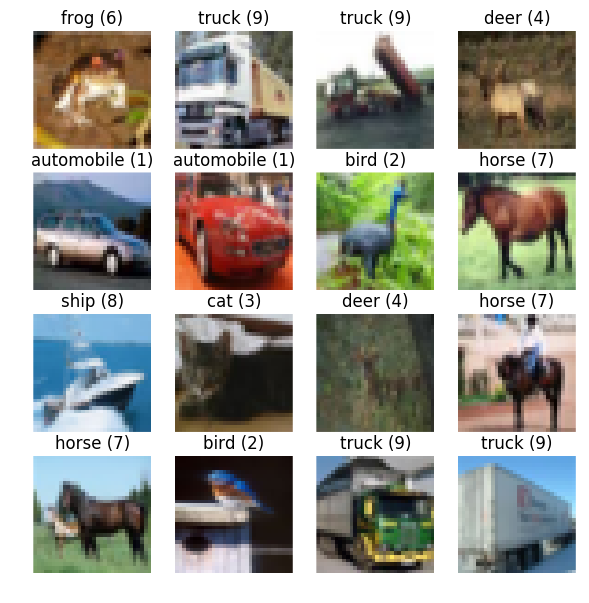

In [15]:
nr, nc = 4, 4
fig, axes = plt.subplots(nr, nc, figsize=(7,7))
for i in range(nr * nc):
    ax = axes[i // nc, i % nc]
    my_imshow(imgs[i], ax = ax)
    label = labels[i]
    label_name = label_names[label]
    ax.set_title("{} ({})".format(label_name, label))
None

In [16]:
x = vectors
y = labels

In [17]:
%%time
h_obj = HierClust()
tree, _ = h_obj.fit(x)

CPU times: user 9.48 s, sys: 217 ms, total: 9.7 s
Wall time: 9.72 s


In [18]:
trees = dict()
top_down_label = "Top Down"
trees[top_down_label] = tree

In [19]:
assignments_pruned = h_obj._get_assignments(tree.prune(depth=3))
avg_gini_impurity_from_assignments(assignments_pruned, labels=y)

0.855207001134754

In [20]:
tree = add_counters_to_tree(tree, y)
#print tree.prune(3).str_display()
avg_gini_impurity_tree(tree.prune(3))

0.8552070011347539

In [21]:
import timeit
def create_timer():
    start = timeit.default_timer()
    def timer():
        return timeit.default_timer() - start
    return timer

In [22]:
#methods = ["single", "average", "complete", "ward"]
methods = ["average", "complete", "ward"]

for method in methods:
    timer = create_timer()
    print("Starting method: {}".format(method))
    try:
        link = sch.linkage(x, method=method)
    except Exception as e:
        print("Exception during clustering: {}".format(e))
    try:
        trees["BU ({})".format(method)] = convert_linkage_to_tree(link, labels = y)
    except Exception as e:
        print("Exception during post-processing: {}".format(e))
    print("Method '{}' elapsed time: {} seconds".format(method, timer()))

Starting method: average
Method 'average' elapsed time: 1.95953798294 seconds
Starting method: complete
Method 'complete' elapsed time: 1.85895299911 seconds
Starting method: ward
Method 'ward' elapsed time: 1.94800186157 seconds


In [23]:
%%time
np.random.seed(1)
random_tree = construct_random_tree(indices = np.arange(len(y)))
random_tree = add_counters_to_tree(random_tree, labels=y)
trees["Random 50% split"] = random_tree

CPU times: user 67.5 ms, sys: 5.48 ms, total: 72.9 ms
Wall time: 71.7 ms


BU (average)
BU (complete)
BU (ward)
Random 50% split
Top Down
CPU times: user 942 ms, sys: 110 ms, total: 1.05 s
Wall time: 977 ms


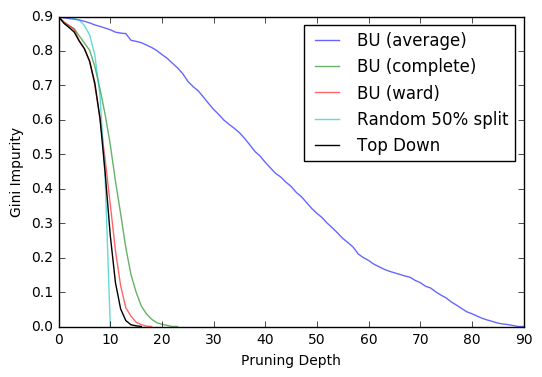

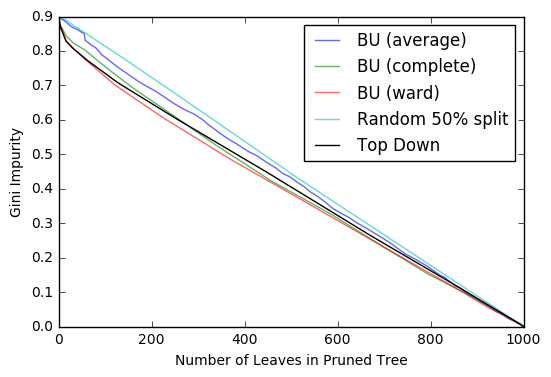

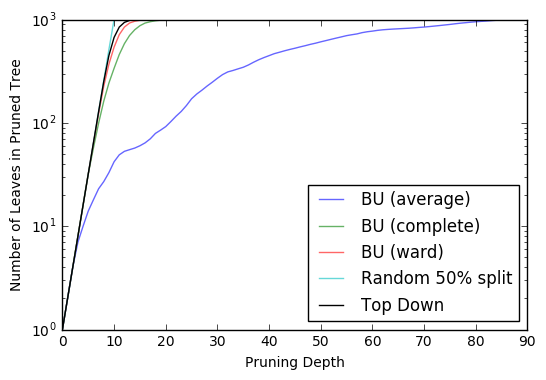

In [24]:
%%time

fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()
fig3, ax3 = plt.subplots()

depths = np.arange(n_obs)
for name in sorted(trees.keys()):
    print(name)
    tree = trees[name]
    total_leaves = tree.num_leaves()
    list_num_leaves = []
    impurity = []
    depths_used = []
    for d in depths:
        pruned_tree = tree.prune(depth = d)
        impurity.append(avg_gini_impurity_tree(pruned_tree))
        num_leaves = pruned_tree.num_leaves()
        list_num_leaves.append(num_leaves)
        depths_used.append(d)
        if num_leaves == total_leaves:
            break
    if name == top_down_label:
        kw = dict(alpha=1.0, color='black')
    else:
        kw = dict(alpha = 0.6)
    ax1.plot(depths_used, impurity, label=name, **kw)
    ax2.plot(list_num_leaves, impurity, label=name, **kw)
    ax3.semilogy(depths_used, list_num_leaves, label=name, **kw)

ax1.legend(loc='best')
ax1.set_ylabel('Gini Impurity')
ax1.set_xlabel('Pruning Depth')

ax2.legend(loc='best')
ax2.set_ylabel('Gini Impurity')
ax2.set_xlabel('Number of Leaves in Pruned Tree')

ax3.legend(loc='best')
ax3.set_ylabel('Number of Leaves in Pruned Tree')
ax3.set_xlabel('Pruning Depth')

None